In [1]:
import collections
import matplotlib.pyplot as plt
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_metadata

In [2]:
training_ids = automl_metadata
test_ids = openml_automl_benchmark

In [3]:
tasks = openml.tasks.list_tasks()

In [4]:
x_train = [tasks[tid]['NumberOfFeatures'] for tid in tasks if tid in training_ids]
y_train = [tasks[tid]['NumberOfInstances'] - 1 for tid in tasks if tid in training_ids]
#z_train = [tasks[tid]['NumberOfClasses'] for tid in tasks if tid in training_ids]
x_test = [tasks[tid]['NumberOfFeatures'] for tid in tasks if tid in test_ids]
y_test = [tasks[tid]['NumberOfInstances'] - 1 for tid in tasks if tid in test_ids]
#z_test = [tasks[tid]['NumberOfClasses'] for tid in tasks if tid in test_ids]

In [5]:
# Find test points for which we fall back
fallback = []
for i in range(len(x_test)):
    add = True
    for j in range(len(x_train)):
        if x_train[j] >= x_test[i] \
            and y_train[j] >= y_test[i]: #\
            #and z_train[j] >= z_test[i]:
            add = False
    if add:
        fallback.append(i)
        
print(len(fallback), fallback, len(x_test))    

6 [3, 21, 23, 24, 30, 33] 39


Text(0.5, 1.0, 'Meta-test datasets')

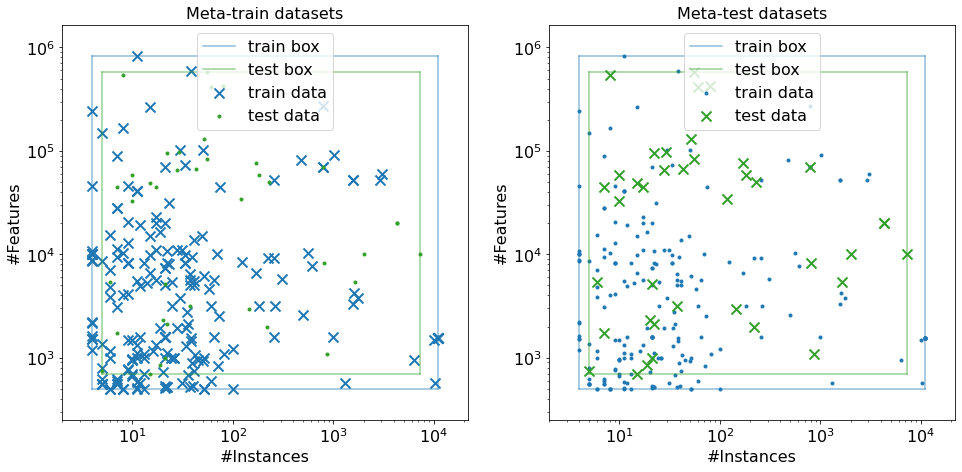

In [6]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ylim = [min(min(y_train), min(y_test))*0.5, max(max(y_train), max(y_test))*2]
xlim = [min(min(x_train), min(x_test))*0.5, max(max(x_train), max(x_test))*2]
#ylim = [100, 900000]


for x,y,l,c in [[x_train, y_train, "train", "#1f78b4"], [x_test, y_test, "test", "#33a02c"]]:
    ax1.plot([min(x), max(x)], [min(y), min(y)], c=c, label="%s box" % l, alpha=0.5)
    ax1.plot([max(x), max(x)], [min(y), max(y)], c=c, alpha=0.5)
    ax1.plot([min(x), max(x)], [max(y), max(y)], c=c, alpha=0.5)
    ax1.plot([min(x), min(x)], [min(y), max(y)], c=c, alpha=0.5)
    ax2.plot([min(x), max(x)], [min(y), min(y)], c=c, label="%s box" % l, alpha=0.5)
    ax2.plot([max(x), max(x)], [min(y), max(y)], c=c, alpha=0.5)
    ax2.plot([min(x), max(x)], [max(y), max(y)], c=c, alpha=0.5)
    ax2.plot([min(x), min(x)], [min(y), max(y)], c=c, alpha=0.5)
    
    if l == "train":
        ax1.scatter(x, y, marker='x', facecolor=c, s=100, linewidth=2, label="%s data" % l)
        ax2.scatter(x, y, marker='.', facecolor=c, label="%s data" % l)
    else:
        ax2.scatter(x, y, marker='x', facecolor=c, s=100, linewidth=2, label="%s data" % l)
        ax1.scatter(x, y, marker='.', facecolor=c, label="%s data" % l)
ax1.legend()
ax2.legend()
    
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel('#Instances')
ax1.set_ylabel('#Features')
ax1.set_title('Meta-train datasets')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xlabel('#Instances')
ax2.set_ylabel('#Features')
ax2.set_title('Meta-test datasets')

In [7]:
fig.savefig('data_distribution.pdf')

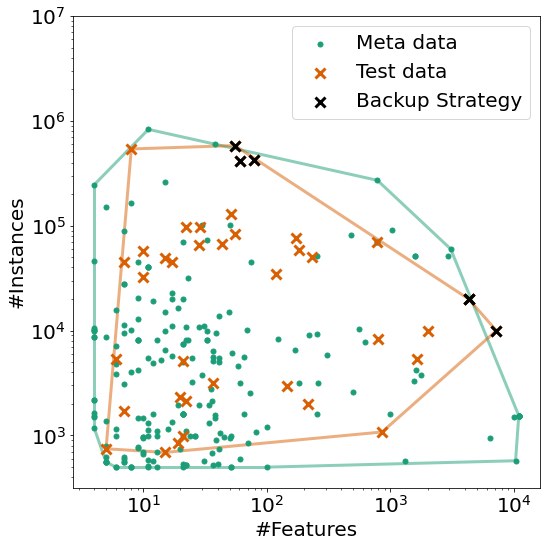

In [8]:
from scipy.spatial import ConvexHull
    
plt.rc('font', size=style_dc["fontsize"])          # controls default text sizes
plt.rc('axes', titlesize=style_dc["fontsize"])     # fontsize of the axes title
plt.rc('axes', labelsize=style_dc["fontsize"])    # fontsize of the x and y labels
plt.rc('xtick', labelsize=style_dc["fontsize"])    # fontsize of the tick labels
plt.rc('ytick', labelsize=style_dc["fontsize"])    # fontsize of the tick labels
plt.rc('legend', fontsize=style_dc["fontsize"])    # legend fontsize
plt.rc('figure', titlesize=style_dc["fontsize"])  # fontsize of the figure title

fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111)
ylim = [min(min(y_train), min(y_test))*0.5, max(max(y_train), max(y_test))*1.1]
xlim = [min(min(x_train), min(x_test))*0.5, max(max(x_train), max(x_test))*1.1]

for x,y,l,c in [[x_train, y_train, "meta", style_dc["colors"][0]], 
                [x_test, y_test, "test", style_dc["colors"][1]]]:
    points =  np.vstack([np.array(x), np.array(y)]).T
    hull = ConvexHull(np.log(points))
    
    for simplex in hull.simplices:
        ax2.plot(points[simplex, 0], points[simplex, 1], c=c, alpha=0.5, 
                 linewidth=style_dc["linewidth"], zorder=0)
    
    if l == "meta":
        ax2.scatter(x, y, marker='.', facecolor=c, s=100,
                    label="%s data" % str.capitalize(l))
    else:
        ax2.scatter(x, y, marker='x', facecolor=c, s=100, 
                    linewidth=style_dc["linewidth"], label="%s data" % str.capitalize(l))

fallback = np.array(fallback)
plt.scatter(np.array(x_test)[fallback], np.array(y_test)[fallback], c='k', 
            marker='x', s=100, linewidth=style_dc["linewidth"], label="Backup Strategy")
         
ax2.legend(fontsize=style_dc["fontsize"])

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('#Features', fontsize=style_dc["fontsize"])
ax2.set_ylabel('#Instances', fontsize=style_dc["fontsize"])
ax2.set_ylim([10**2.5, 10**7])
fig.tight_layout()
fig.savefig('/tmp/data_dist_1.png')

[(11, 829200), (38, 595211), (785, 270911), (1025, 91999), (3073, 59999), (10936, 1544), (10936, 1544), (10936, 1544), (10936, 1544), (10936, 1544), (10936, 1544), (10937, 1544)]


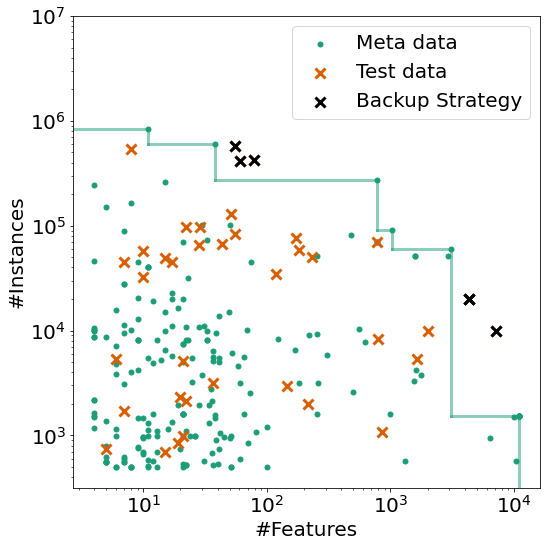

In [9]:
from scipy.spatial import ConvexHull
    
plt.rc('font', size=style_dc["fontsize"])          # controls default text sizes
plt.rc('axes', titlesize=style_dc["fontsize"])     # fontsize of the axes title
plt.rc('axes', labelsize=style_dc["fontsize"])    # fontsize of the x and y labels
plt.rc('xtick', labelsize=style_dc["fontsize"])    # fontsize of the tick labels
plt.rc('ytick', labelsize=style_dc["fontsize"])    # fontsize of the tick labels
plt.rc('legend', fontsize=style_dc["fontsize"])    # legend fontsize
plt.rc('figure', titlesize=style_dc["fontsize"])  # fontsize of the figure title

fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111)
ylim = [min(min(y_train), min(y_test))*0.5, max(max(y_train), max(y_test))*1.1]
xlim = [min(min(x_train), min(x_test))*0.5, max(max(x_train), max(x_test))*1.1]

for x,y,l,c in [[x_train, y_train, "meta", style_dc["colors"][0]], 
                [x_test, y_test, "test", style_dc["colors"][1]]]:
    
    if l == "meta":
        ax2.scatter(x, y, marker='.', facecolor=c, s=100,
                    label="%s data" % str.capitalize(l))
        pareto_front = []
        for x_, y_ in zip(x, y):
            if np.sum((np.array(x) > x_) & (np.array(y) > y_)) == 0:
                pareto_front.append((x_, y_))
        pareto_front.sort()
        print(pareto_front)
        ax2.plot(
                (0, pareto_front[0][0]), 
                (pareto_front[0][1], pareto_front[0][1]),
                c=c, alpha=0.5, 
                linewidth=style_dc["linewidth"], zorder=0
            )
        for i in range(1, len(pareto_front)):
            ax2.plot(
                (pareto_front[i-1][0], pareto_front[i-1][0]), 
                (pareto_front[i-1][1], pareto_front[i][1]),
                c=c, alpha=0.5, 
                linewidth=style_dc["linewidth"], zorder=0
            )
            ax2.plot(
                (pareto_front[i-1][0], pareto_front[i][0]), 
                (pareto_front[i][1], pareto_front[i][1]),
                c=c, alpha=0.5, 
                linewidth=style_dc["linewidth"], zorder=0
            )
        ax2.plot(
            (pareto_front[i][0], pareto_front[i][0]), 
            (pareto_front[i][1], 0),
            c=c, alpha=0.5, 
            linewidth=style_dc["linewidth"], zorder=0
        )
    else:
        ax2.scatter(x, y, marker='x', facecolor=c, s=100, 
                    linewidth=style_dc["linewidth"], label="%s data" % str.capitalize(l))

fallback = np.array(fallback)
plt.scatter(np.array(x_test)[fallback], np.array(y_test)[fallback], c='k', 
            marker='x', s=100, linewidth=style_dc["linewidth"], label="Backup Strategy")
         
ax2.legend(fontsize=style_dc["fontsize"])

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('#Features', fontsize=style_dc["fontsize"])
ax2.set_ylabel('#Instances', fontsize=style_dc["fontsize"])
ax2.set_ylim([10**2.5, 10**7])
fig.tight_layout()
fig.savefig('/tmp/data_dist_1_pareto_front.png')

In [10]:
#from scipy.spatial import ConvexHull
#    
#plt.rc('font', size=style_dc["fontsize"])          # controls default text sizes
#plt.rc('axes', titlesize=style_dc["fontsize"])     # fontsize of the axes title
#plt.rc('axes', labelsize=style_dc["fontsize"])    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=style_dc["fontsize"])    # fontsize of the tick labels
#plt.rc('ytick', labelsize=style_dc["fontsize"])    # fontsize of the tick labels
#plt.rc('legend', fontsize=style_dc["fontsize"])    # legend fontsize
#plt.rc('figure', titlesize=style_dc["fontsize"])  # fontsize of the figure title
#
#fig = plt.figure(figsize=(8,8))
#ax2 = fig.add_subplot(111)
#ylim = [min(min(y_train), min(y_test))*0.5, max(max(y_train), max(y_test))*1.1]
#xlim = [min(min(x_train), min(x_test))*0.5, max(max(x_train), max(x_test))*1.1]
#
#for x,y,l,c in [[z_train, y_train, "meta", style_dc["colors"][0]], 
#                [z_test, y_test, "test", style_dc["colors"][1]]]:
#    points =  np.vstack([np.array(x), np.array(y)]).T
#    hull = ConvexHull(np.log(points))
#    
#    for simplex in hull.simplices:
#        ax2.plot(points[simplex, 0], points[simplex, 1], c=c, alpha=0.5, 
#                 linewidth=style_dc["linewidth"], zorder=0)
#    
#    if l == "meta":
#        ax2.scatter(x, y, marker='.', facecolor=c, s=100,
#                    label="%s data" % str.capitalize(l))
#    else:
#        ax2.scatter(x, y, marker='x', facecolor=c, s=100, 
#                    linewidth=style_dc["linewidth"], label="%s data" % str.capitalize(l))
#
#fallback = np.array(fallback)
#plt.scatter(np.array(z_test)[fallback], np.array(y_test)[fallback], c='k', 
#            marker='x', s=100, linewidth=style_dc["linewidth"], label="Backup Strategy")
#        
#ax2.legend(fontsize=style_dc["fontsize"])
#
#ax2.set_yscale('log')
#ax2.set_xscale('log')
#ax2.set_xlabel('#Classes', fontsize=style_dc["fontsize"])
#ax2.set_ylabel('#Instances', fontsize=style_dc["fontsize"])
#ax2.set_ylim([10**2.5, 10**7])
#fig.tight_layout()
#fig.savefig('/tmp/data_dist_2.png')

In [11]:
# test data
max_length = 5
test_task_shapes = {value['name']: {
    'name': "\href{https://www.openml.org/d/" + str(value['did']) + "}{" 
    + (value['name'] if len(value["name"]) < max_length else 
       value['name'][:max_length] + "~\dots").replace("_", "\_") 
    + "}",
    'tid': "\href{https://www.openml.org/t/" + str(value['tid']) + "}{" + str(value['tid']) + "}",
    '\#obs': value['NumberOfInstances'],
    '\#feat': value['NumberOfFeatures'], 
    '\#cls': value['NumberOfClasses']
} for tid, value in tasks.items() if tid in test_ids}
test_task_shapes = pd.DataFrame(test_task_shapes).transpose()
latex_table = test_task_shapes.sort_values(axis=0, by='\#feat', ascending=False)
pd.options.display.max_colwidth = 100
tmp = latex_table.to_latex(index=False, escape=False)
print(tmp)

\begin{tabular}{lllll}
\toprule
                                              name &                                            tid &  \#obs & \#feat & \#cls \\
\midrule
\href{https://www.openml.org/d/41165}{rober~\dots} & \href{https://www.openml.org/t/168794}{168794} &  10000 &   7201 &    10 \\
\href{https://www.openml.org/d/41161}{ricca~\dots} & \href{https://www.openml.org/t/168797}{168797} &  20000 &   4297 &     2 \\
\href{https://www.openml.org/d/41159}{guill~\dots} & \href{https://www.openml.org/t/168796}{168796} &  20000 &   4297 &     2 \\
\href{https://www.openml.org/d/41163}{dilbe~\dots} & \href{https://www.openml.org/t/189871}{189871} &  10000 &   2001 &     5 \\
\href{https://www.openml.org/d/41142}{chris~\dots} & \href{https://www.openml.org/t/189861}{189861} &   5418 &   1637 &     2 \\
 \href{https://www.openml.org/d/1468}{cnae-~\dots} & \href{https://www.openml.org/t/167185}{167185} &   1080 &    857 &     9 \\
\href{https://www.openml.org/d/41164}{faber~\dots} & \hr

In [12]:
max_length = 5
test_task_shapes = {value['name']: {
    'name': "\href{https://www.openml.org/d/" + str(value['did']) + "}{" 
    + (value['name'] if len(value["name"]) < max_length else 
       value['name'][:max_length] + "~\dots").replace("_", "\_") 
    + "}",
    'tid': "\href{https://www.openml.org/t/" + str(value['tid']) + "}{" + str(value['tid']) + "}",
    '\#obs': value['NumberOfInstances'],
    '\#feat': value['NumberOfFeatures'], 
    '\#cls': value['NumberOfClasses']
} for tid, value in tasks.items() if tid in training_ids}
test_task_shapes = pd.DataFrame(test_task_shapes).transpose()
latex_table = test_task_shapes.sort_values(axis=0, by='\#feat', ascending=False)
pd.options.display.max_colwidth = 100
tmp = latex_table[:83].to_latex(index=False, escape=False)
print(tmp)

\begin{tabular}{lllll}
\toprule
                                              name &                                            tid &  \#obs & \#feat & \#cls \\
\midrule
\href{https://www.openml.org/d/1146}{OVA\_P~\dots} &   \href{https://www.openml.org/t/75121}{75121} &   1545 &  10937 &     2 \\
\href{https://www.openml.org/d/1161}{OVA\_C~\dots} &   \href{https://www.openml.org/t/75125}{75125} &   1545 &  10936 &     2 \\
\href{https://www.openml.org/d/1128}{OVA\_B~\dots} &   \href{https://www.openml.org/t/75114}{75114} &   1545 &  10936 &     2 \\
\href{https://www.openml.org/d/1130}{OVA\_L~\dots} &   \href{https://www.openml.org/t/75115}{75115} &   1545 &  10936 &     2 \\
\href{https://www.openml.org/d/1134}{OVA\_K~\dots} &   \href{https://www.openml.org/t/75116}{75116} &   1545 &  10936 &     2 \\
\href{https://www.openml.org/d/1166}{OVA\_O~\dots} &   \href{https://www.openml.org/t/75126}{75126} &   1545 &  10936 &     2 \\
\href{https://www.openml.org/d/1142}{OVA\_E~\dots} &   \

In [13]:
tmp = latex_table[83:166].to_latex(index=False, escape=False)
print(tmp)

\begin{tabular}{lllll}
\toprule
                                              name &                                            tid &  \#obs & \#feat & \#cls \\
\midrule
\href{https://www.openml.org/d/1044}{eye\_m~\dots} & \href{https://www.openml.org/t/189779}{189779} &  10936 &     28 &     3 \\
\href{https://www.openml.org/d/40982}{steel~\dots} & \href{https://www.openml.org/t/168785}{168785} &   1941 &     28 &     7 \\
 \href{https://www.openml.org/d/715}{fri\_c~\dots} &   \href{https://www.openml.org/t/75136}{75136} &   1000 &     26 &     2 \\
 \href{https://www.openml.org/d/903}{fri\_c~\dots} &   \href{https://www.openml.org/t/75199}{75199} &   1000 &     26 &     2 \\
\href{https://www.openml.org/d/40677}{led24~\dots} & \href{https://www.openml.org/t/189841}{189841} &   3200 &     25 &    10 \\
 \href{https://www.openml.org/d/1497}{wall-~\dots} &   \href{https://www.openml.org/t/75235}{75235} &   5456 &     25 &     4 \\
\href{https://www.openml.org/d/40971}{colli~\dots} & \hr

In [14]:
tmp = latex_table[166:].to_latex(index=False, escape=False)
print(tmp)

\begin{tabular}{lllll}
\toprule
                                               name &                                            tid &  \#obs & \#feat & \#cls \\
\midrule
   \href{https://www.openml.org/d/335}{monks~\dots} &     \href{https://www.openml.org/t/3055}{3055} &    554 &      7 &     2 \\
   \href{https://www.openml.org/d/334}{monks~\dots} &     \href{https://www.openml.org/t/3054}{3054} &    601 &      7 &     2 \\
   \href{https://www.openml.org/d/184}{kropt~\dots} &     \href{https://www.openml.org/t/2122}{2122} &  28056 &      7 &    18 \\
   \href{https://www.openml.org/d/333}{monks~\dots} &     \href{https://www.openml.org/t/3053}{3053} &    556 &      7 &     2 \\
   \href{https://www.openml.org/d/310}{mammo~\dots} &     \href{https://www.openml.org/t/3048}{3048} &  11183 &      7 &     2 \\
\href{https://www.openml.org/d/40922}{Run\_o~\dots} & \href{https://www.openml.org/t/167103}{167103} &  88588 &      7 &     2 \\
   \href{https://www.openml.org/d/737}{space~\dot